In [1]:
import os
import importlib
from timeit import timeit
import logging
import sys
import importlib
import time
import multiprocessing as mp
import multiprocessing.pool

import numpy as np
import pandas as pd
import scipy
import h5py
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numba

import ms_utils
import browser
import interface
import ms_database
import ms_run_files

import sandbox

import line_profiler
profile = line_profiler.LineProfiler()
# heat.evolve = profile(heat.evolve)
# profile.print_stats()

def reload():
    importlib.reload(ms_run_files)
    importlib.reload(ms_utils)
    importlib.reload(browser)
    importlib.reload(interface)
    importlib.reload(sandbox)
    importlib.reload(ms_database)
   

In [2]:
reload()
inet = ms_run_files.Network("/home/sander/Documents/Proteomics/data/ecoli/28Oct2016_060.inet.hdf")
inet.dimensions

['FRAGMENT_LOGINT', 'FRAGMENT_MZ', 'PRECURSOR_MZ', 'PRECURSOR_RT']

In [3]:
fints, fmzs, pmzs, prts = inet.get_ion_coordinates()

In [4]:
isotopic_distance = 1.002861
# isotopic_distance = 130.202861
ppm = 10
to_select_per_sample = 100000

In [5]:
c = np.argpartition(fints, - to_select_per_sample)[-to_select_per_sample:]
c = c[np.argsort(fmzs[c])]
mzs = fmzs[c]
if isotopic_distance > 0:
    lower_limits = np.searchsorted(
        mzs,
        (mzs + isotopic_distance) / (1 + ppm * 10**-6),
        "left"
    )
else:
    lower_limits = np.arange(len(mzs)) + 1
upper_limits = np.searchsorted(
    mzs,
    (mzs + isotopic_distance) * (1 + ppm * 10**-6),
    "right"
)
indptr = np.zeros(inet.node_count + 1, np.int64)
indptr[c + 1] = upper_limits - lower_limits
indptr = np.cumsum(indptr)
order = np.argsort(c)
indices = np.concatenate(
    [
        c[low: high] for low, high in zip(lower_limits[order], upper_limits[order])
    ]
)
len(indices)

901430

In [6]:
indices1 = np.repeat(np.arange(inet.node_count), np.diff(indptr))
indices2 = indices

<IPython.core.display.Javascript object>


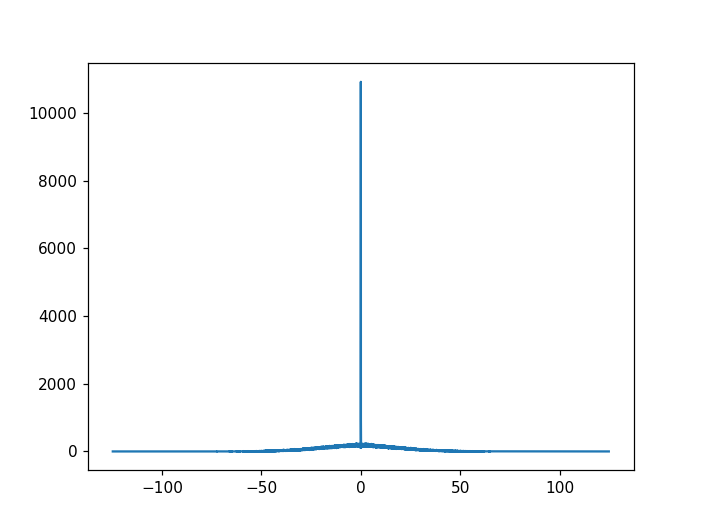

In [7]:
%matplotlib notebook

mz_diffs = pmzs[indices1] - pmzs[indices2]
rt_diffs = prts[indices1] - prts[indices2]

# plt.scatter(mz_diffs, rt_diffs)

# sns.jointplot(mz_diffs, rt_diffs, kind="hex")

a, b = np.unique(
    np.round(rt_diffs, 2),
    return_counts=True
)
plt.plot(a, b)

# plt.plot(np.arange(len(rt_diffs))/(len(rt_diffs) - 1), (np.sort(rt_diffs)))
# plt.plot(np.arange(len(rt_diffs_rnd))/(len(rt_diffs_rnd) - 1), (np.sort(np.abs(rt_diffs_rnd))))

In [ ]:
a = np.sort(np.abs(rt_diffs))
b = np.sort(np.abs(rt_diffs_rnd))
c = np.searchsorted(a,b, "left")

In [ ]:
i = np.arange(len(b))/len(b)
j = c/len(a)
l = ((1-i)+(j))
plt.plot(b, l)

In [15]:
# import sklearn.cluster
# clusterer = sklearn.cluster.DBSCAN(eps=10, min_samples=3).fit(
#     np.stack([mz_diffs, rt_diffs]).T
# )

g = np.abs(mz_diffs) < 10
g &= np.abs(rt_diffs) < 0.2

import hdbscan
clusterer = hdbscan.HDBSCAN().fit(
    np.stack(
        [
            mz_diffs[g],
            rt_diffs[g]
        ]
    ).T
)

<IPython.core.display.Javascript object>


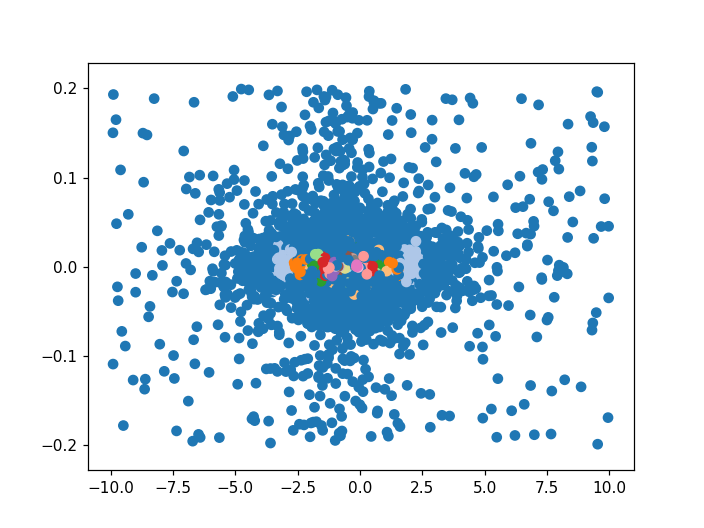

In [16]:
%matplotlib notebook

plt.scatter(
    mz_diffs[g],
    rt_diffs[g],
    c=clusterer.labels_,
#     cmap=\"gist_ncar\"
    cmap="tab20"
)


In [ ]:
@numba.njit(cache=True, nogil=True)
def increase_buffer(buffer, max_batch=10**7):
    new_buffer = np.empty(buffer.shape[0] + max_batch, np.int64)
    new_buffer[:len(buffer)] = buffer
    return new_buffer

@numba.njit(cache=True, nogil=True)
def __determine_precursor_edges(
    queries,
    lower_limits,
    upper_limits,
    coordinates,
    max_errors,
):
    indptr = np.zeros(len(queries), np.int64)
    indices = np.empty(10**7, np.int64)
    total = 0
    for index, query in enumerate(queries):
        low_limit = lower_limits[query]
        high_limit = upper_limits[query]
        candidate_count = high_limit - low_limit
        if candidate_count == 0:
            continue
        elif (candidate_count + total) >= len(indices):
            indices = increase_buffer(indices)
        dists = coordinates[low_limit: high_limit] - coordinates[query]
        dists /= max_errors
#         TODO: what if error==0?
        dists = dists**2
        projected_dists = np.sum(dists, axis=1)
        projected_dists = np.sqrt(projected_dists)
        candidates = low_limit + np.flatnonzero(projected_dists <= 1)
        candidate_count = len(candidates)
        indices[total: total + candidate_count] = candidates
        indptr[index] = candidate_count
        total += candidate_count
    return (indptr, indices[:total])

def determine_precursor_edges(
    self,
    errors,
    thread_count=1,
):
    precursor_coordinates = np.stack(
        self.get_ion_coordinates(self.precursor_dimensions)
    ).T
    max_errors = np.array(
        [errors[dimension] for dimension in self.precursor_dimensions]
    )
    rt_coordinates = self.get_ion_coordinates("PRECURSOR_RT")
    lower_limits = np.arange(len(rt_coordinates)) + 1
    upper_limits = np.searchsorted(
        rt_coordinates,
        rt_coordinates + errors["PRECURSOR_RT"],
        "right"
    )
    with multiprocessing.pool.ThreadPool(thread_count) as p:
        results = p.starmap(
            __determine_precursor_edges,
            [
                (
                    np.arange(
                        (i * self.node_count) // thread_count,
                        ((i + 1) * self.node_count) // thread_count
                    ),
                    lower_limits,
                    upper_limits,
                    precursor_coordinates,
                    max_errors
                ) for i in range(thread_count)
            ]
        )
    indptr = np.empty(self.node_count + 1, np.int64)
    indptr[0] = 0
    indptr[1:] = np.cumsum(np.concatenate([r[0] for r in results]))
    indices = np.concatenate([r[1] for r in results])
#     self.write_group("edges")
#     self.write_dataset(
#         "indptr",
#         indptr,
#         parent_group_name="edges"
#     )
#     self.write_dataset(
#         "indices",
#         indices,
#         parent_group_name="edges"
#     )
#     self.write_attr("edge_count", len(indices))
#     for parameter_key, parameter_value in parameters.items():
#         if parameter_key.startswith("max_edge_absolute_error"):
#             if parameter_key[19:] in self.dimensions:
#                 self.write_attr(parameter_key, parameter_value)
    return indptr, indices

In [ ]:
r = determine_precursor_edges(
    inet,
    {
        "PRECURSOR_RT": 0.1,
        "PRECURSOR_MZ": 0,
    },
    thread_count=8,
)
r

In [ ]:
timeit(
    lambda: determine_precursor_edges(
        inet,
        max_errors=np.array((5, 0.1)),
        max_rt_absolute_error=0.1,
        thread_count=8,
    ),
    number=1
)

In [ ]:
b = r[1]
# a = np.repeat(np.arange(len(r[0]) - 1), np.diff(r[0]))
a = r[0]
print(len(a), len(b))

In [ ]:
pmzs, prts = inet.get_ion_coordinates(inet.precursor_dimensions)
fints, fmzs = inet.get_ion_coordinates(["FRAGMENT_LOGINT", "FRAGMENT_MZ"])

In [ ]:
to_select_per_sample = 100000
c = np.argpartition(fints, - to_select_per_sample)[-to_select_per_sample:]

In [ ]:
a = np.repeat(np.arange(len(a) - 1), np.diff(a))

In [ ]:
x = np.isin(a,c)

In [ ]:


mzds = np.repeat(pmzs, np.diff(a)) - pmzs[b]
rtds = np.repeat(prts, np.diff(a)) - prts[b]

In [ ]:
%matplotlib notebook 
plt.scatter(pmzs[c], prts[c])
# a,b = np.unique(
#     np.round(
#         prts[c],
#         3
#     ),
#     return_counts=True
# )
# plt.plot(a, b)

In [ ]:
reload()

inets = []
evis = []
anis = []
# in_folder = "/home/sander/Documents/Proteomics/data/ion_networks"
in_folder = "/home/sander/Documents/Proteomics/data/ecoli3"
# in_folder = "/home/sander/Documents/Proteomics/data/jpt/APEX"
for file_name in ms_utils.get_file_names_with_extension([in_folder], ".inet.hdf"):
    inets.append(
        ms_run_files.Network(
            file_name
        )
    )
    evis.append(
        ms_run_files.Evidence(
            file_name
        )
    )
    anis.append(
        ms_run_files.Annotation(
            file_name
        )
    )

In [ ]:
ani_indices = anis[0].get_dataset("indices", 'edge_candidates')
ani_indptr = anis[0].get_dataset("indptr", 'edge_candidates')

In [ ]:
anis[0].get_dataset

In [ ]:
from math import sqrt
from numba import njit, jit, guvectorize
import timeit
import numpy as np

@njit
def square_sum(arr):
    a = 0.
    for i in range(arr.size):
        a = np.sqrt(a**2 + arr[i]**2)  # sqrt and square are cpu-intensive!
    return a

@njit
def is_close(x, y, max_errors):
    z = x - y
    z /= max_errors
    z = np.sqrt(np.sum(z**2))
    return z < 1

@guvectorize(["void(float64[:], float64[:], float64[:], bool_[:])"], "(n), (n), (n) -> ()", target="parallel", nopython=True)
def row_sum_gu(input, coordinate, max_errors, output) :
    output[0] = is_close(input, coordinate, max_errors)

In [ ]:
rows = int(64)
columns = int(1e6)

input_array = np.random.random((rows, columns))
output_array = np.zeros((rows))
# row_sum_jit(input_array, output_array.copy())
t1 = timeit.timeit(
    lambda:row_sum_jit(input_array, output_array.copy()),
#     lambda: np.sum(rows),
    number=1
)
t2 = timeit.timeit(
    lambda:row_sum_gu(input_array, output_array.copy()),
#     lambda: np.sum(rows),
    number=1
)
print(t1,t2)

In [ ]:
np.flatnonzero(row_sum_gu(x,y,m))

In [ ]:
reload()

ion_network_file_name = "/home/sander/Documents/Proteomics/data/ecoli2/28Oct2016_064.inet.hdf"
csv_file_name = "/home/sander/Documents/Proteomics/data/ecoli/28Oct2016_064.inet.csv"

ms_run_files.Network.write_edges = profile(ms_run_files.Network.write_edges)

parameters = ms_utils.read_parameters_from_json_file(
#     file_name=parameter_file_name,
    default="create"
)
network = ms_run_files.Network(
    ion_network_file_name,
    new_file=True,
)
data = ms_utils.read_centroided_csv_file(
    csv_file_name,
    parameters,
)
network.create_from_data(data, parameters)

In [ ]:
profile.print_stats()

In [ ]:
self_inet = inets[0]
self_evi = evis[0]
other_inet = inets[1]
other_evi = evis[1]

self_alignment = self_evi.get_aligned_nodes_from_group(
    other_evi.file_name_base,
    return_as_mask=False
)
other_alignment = other_evi.get_aligned_nodes_from_group(
    self_evi.file_name_base,
    return_as_mask=False
)
# other_logints = inets[other_name].get_ion_coordinates(
#     "FRAGMENT_LOGINT",
#     indices=other_alignment
# )
# logints[i, self_alignment] = other_logints

In [ ]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)

ind_start = 0
ind_size = len(self_alignment)

a1 = self_inet.get_ion_coordinates("PRECURSOR_RT", indices = self_alignment[ind_start: ind_start+ind_size])
b1 = self_inet.get_ion_coordinates("PRECURSOR_MZ", indices = self_alignment[ind_start: ind_start+ind_size])
a2 = other_inet.get_ion_coordinates("PRECURSOR_RT", indices = other_alignment[ind_start: ind_start+ind_size])
b2 = other_inet.get_ion_coordinates("PRECURSOR_MZ", indices = other_alignment[ind_start: ind_start+ind_size])

# ax=

start_edges = list(zip(a1, b1))
end_edges = list(zip(a2, b2))
# colors = positive_counts[selection] - negative_counts[selection]
edges = np.array(list(zip(start_edges, end_edges)))

x = ax.add_collection(
    matplotlib.collections.LineCollection(edges),
)
x.set_color("grey")
ax.scatter(a1, b1, marker=".", c="g", zorder=10)
ax.scatter(a2, b2, marker=".", c="r", zorder=10)
ax.set_xlabel("PRECURSOR_RT")
ax.set_ylabel("PRECURSOR_MZ")
# sns.jointplot(a1[ind_start: ind_start+ind_size], a2[ind_start: ind_start+ind_size], kind="kde",gridsize=100)

In [ ]:
import matplotlib
sorted(matplotlib.colors.__dict__['CSS4_COLORS'])

In [ ]:
# repro = evi.get_aligned_nodes_from_group()

In [ ]:
inet=inets[0]
evi=evis[0]

%matplotlib notebook
coords = inet.get_ion_coordinates(inet2.dimensions)
print(inet.dimensions)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# repro = evi.get_aligned_nodes_from_group()

selection = (coords[3] > 30) & (coords[3] < 30.2)
selection &= (coords[2] < 2000)
selection &= (coords[1] < 900)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
ax.scatter(
    coords[1][selection],
    coords[3][selection],
    coords[2][selection],
    marker=".",
    c=coords[0][selection],
    cmap="RdYlGn"
)
ax.set_xlabel(inet.dimensions[1])
ax.set_ylabel(inet.dimensions[3])
ax.set_zlabel(inet.dimensions[2])

In [ ]:
reload()

an = annotation.Annotation(
    evidence=evis[0],
    database="/home/sander/Documents/Proteomics/data/databases/hdf/crap_ecoli_concatenated_decoy.hdf",
    parameters={
        "annotation_ppm": 20,
    },
    logger=logger
)

In [ ]:
self=inets[1]
# indptr, indices = self.get_edges(
#     indptr_and_indices=True
# )
# x, y = self.get_edges(return_as_scipy_csr=False)

In [ ]:
rts = self.get_ion_coordinates("PRECURSOR_RT")
rts[:1000000]

In [ ]:
reload()

self = inets[0]
other = inets[1]
# self_ints, self_mzs, self_pmzs, self_rts = self.get_ion_coordinates()
# other_ints, other_mzs, other_pmzs, other_rts = other.get_ion_coordinates()
# calibrated_self_rts = sandbox.calibrate_precursor_rt(self, other, ppm=10)

In [ ]:
self_mzs = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_01_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_MZ"]
).values.flatten()
other_mzs = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_08_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_MZ"]
).values.flatten()

self_logints = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_01_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_LOGINT"]
).values.flatten()
other_logints = pd.read_csv(
    "/home/sander/Documents/Proteomics/data/jpt/APEX/200117_JPTmix_prop_Fullloop_08_Apex3DIons.inet.csv",
    usecols=["FRAGMENT_LOGINT"]
).values.flatten()

In [ ]:
# le_indices = np.concatenate(
#     [
#         start + np.argpartition(
#             ions["INTENSITY"][start: end], - to_select_per_sample
#         )[-to_select_per_sample:] for start, end in zip(
#             start_indices[:-1],
#             start_indices[1:]
#         )
#     ]
# )


In [ ]:
calibration_ions = 50000
self_ions = np.argpartition(self_logints, -calibration_ions)[-calibration_ions:]
other_ions = np.argpartition(other_logints, -calibration_ions)[-calibration_ions:]

In [ ]:
self_mzs = self_mzs[self_ions]
other_mzs = other_mzs[other_ions]

In [ ]:
np.sort(self_mzs), np.sort(other_mzs)

In [ ]:
self_mzs = self.get_ion_coordinates("FRAGMENT_MZ")
other_mzs = other.get_ion_coordinates("FRAGMENT_MZ")
# self_indices, other_indices = sandbox.quick_align(self_mzs, other_mzs, ppm=10)
# self_rts = self.get_ion_coordinates("PRECURSOR_RT")
# other_rts = other.get_ion_coordinates("PRECURSOR_RT", indices=other_indices)

In [ ]:
self_inds = np.repeat(0, len(self_mzs))
other_inds = np.repeat(1, len(other_mzs))

In [ ]:
mzs = np.concatenate([self_mzs, other_mzs])
inds = np.concatenate([self_inds, other_inds])
order = np.argsort(mzs)
mzs = mzs[order]
inds = inds[order]

In [ ]:
mz_diffs = np.diff(mzs)
ind_diffs = np.diff(inds)
x = np.concatenate([mz_diffs[ind_diffs==1], -mz_diffs[ind_diffs==-1]])

In [ ]:
x = (mz_diffs[:-2] < mz_diffs[1:-1]) & (mz_diffs[1:-1] < mz_diffs[2:])
x &= ind_diffs[1:-1] != 0
x = mz_diffs[1:-1][x] * -ind_diffs[1:-1][x]

In [ ]:
np.quantile(
    mz_diffs[ind_diffs==-1] * 10**6 / mzs[:-1][ind_diffs==-1],
    0.5
)

In [ ]:
%matplotlib notebook

# s = np.concatenate([mz_diffs[ind_diffs==1], -mz_diffs[ind_diffs==-1]])

plt.scatter(
    mzs[:-1][ind_diffs==1],
    mz_diffs[ind_diffs==1] * 10**6 / mzs[:-1][ind_diffs==1]
#     np.sort(self_mzs),
#     np.sort(other_mzs) - np.sort(self_mzs),
#     10**6 * (np.sort(self_mzs) - np.sort(other_mzs)) / np.sort(self_mzs)
)

In [ ]:
%matplotlib notebook

a, b = np.unique(np.round(x,3), return_counts=True)
print(np.quantile(x, np.arange(101)/100), np.median(x))
# plt.plot(a,b)
plt.plot(np.quantile(x, np.arange(101)/100))

In [ ]:
new_self_rts = []
for self_start_index, self_end_index, other_rt_start, other_rt_end in zip(
    self_indices[:-1],
    self_indices[1:],
    other_rts[:-1],
    other_rts[1:]
):
#     if self_end_index == self_start_index:
#         continue
    self_rt_start = self_rts[self_start_index]
    self_rt_end = self_rts[self_end_index]
    if self_rt_start == self_rt_end:
        new_rts = np.repeat(other_rt_start, self_end_index - self_start_index)
    else:
        slope = (other_rt_end - other_rt_start) / (self_rt_end - self_rt_start)
        new_rts = other_rt_start + slope * (
            self_rts[self_start_index: self_end_index] - self_rt_start
        )
    new_self_rts.append(new_rts)
new_self_rts.append([other_rts[-1]])
new_self_rts = np.concatenate(new_self_rts)

In [ ]:
new_self_rts.shape[0] - self_rts.shape[0]

In [ ]:
self_rts = self.get_ion_coordinates("PRECURSOR_RT")

In [ ]:
%matplotlib notebook

plt.scatter(self_rts, self_rts - calibrated_self_rts)

In [ ]:
reload()

self_ints, self_mzs, self_dts, self_rts = self.get_ion_coordinates()
other_ints, other_mzs, other_dts, other_rts = other.get_ion_coordinates()
self_indices, other_indices = sandbox.quick_align(self_mzs, other_mzs, ppm=10)

In [ ]:
# s = slice(0, None, 1000)
a1 = self_rts[self_indices]
a2 = other_rts[other_indices]
c = self_dts[self_indices] - other_dts[other_indices]

In [ ]:
ppm=10

self_mz_order = np.argsort(self_mzs)
other_mz_order = np.argsort(other_mzs)
max_mz_diff = 1 + ppm * 10**-6
low_limits = np.searchsorted(
    self_mzs[self_mz_order],
    other_mzs[other_mz_order] / max_mz_diff,
    "left"
)
high_limits = np.searchsorted(
    self_mzs[self_mz_order],
    other_mzs[other_mz_order] * max_mz_diff,
    "right"
)
other_rt_order = np.argsort(other_mz_order)
self_indices = np.concatenate(
    [
        self_mz_order[l:h] for l, h in zip(
            low_limits[other_rt_order],
            high_limits[other_rt_order]
        )
    ]
)
other_indices = np.repeat(
    np.arange(len(other_rt_order)),
    high_limits[other_rt_order] - low_limits[other_rt_order]
)

In [ ]:
%matplotlib notebook

plt.plot(a1, a2)

In [ ]:
%matplotlib notebook

# plt.plot(a1, a2)
# plt.scatter(a1, a2, marker=".", c=c, cmap="RdYlGn")
# sns.jointplot(a1, a2, kind="hex", gridsize=200)
# sns.jointplot(self_rts[self_indices], other_rts[other_indices], kind="hex", gridsize=100)
plt.scatter(self_rts[self_indices], other_rts[other_indices], marker=".")

In [ ]:
%matplotlib notebook

a,b=np.unique(np.round(c,0), return_counts=True)
plt.plot(a,b)

In [ ]:
self_rts = self.get_ion_coordinates("PRECURSOR_RT")
other_rts = other.get_ion_coordinates("PRECURSOR_RT", indices=other_indices)
new_self_rts = []
for self_start_index, self_end_index, other_rt_start, other_rt_end in zip(
    self_indices[:-1],
    self_indices[1:],
    other_rts[:-1],
    other_rts[1:]
):
    self_rt_start = self_rts[self_start_index]
    self_rt_end = self_rts[self_end_index]
    if self_rt_start == self_rt_end:
        new_rts = np.repeat(other_rt_start, self_end_index - self_start_index)
    else:
        slope = (other_rt_end - other_rt_start) / (self_rt_end - self_rt_start)
        new_rts = other_rt_start + slope * (
            self_rts[self_start_index: self_end_index] - self_rt_start
        )
    new_self_rts.append(new_rts)
new_self_rts.append([other_rts[-1]])
new_self_rts = np.concatenate(new_self_rts)

In [ ]:
# %matplotlib notebook

# s = slice(0, None, 1000)
# plt.scatter(new_self_rts[s], self_rts[s])

In [ ]:
ints, mzs, pmzs, rts = inets[0].get_ion_coordinates()

In [ ]:
reload()

ali = evis[0].get_alignment(evis[1])
# pairwise_alignment = inets[0].align_nodes(
#     inets[1],
#     parameters
# )
# ali = [
#     pairwise_alignment.T.tocsr().indices,
#     pairwise_alignment.indices
# ]
# a = np.repeat(np.arange(pairwise_alignment.shape[0]), np.diff(pairwise_alignment.indptr))
# aa = pairwise_alignment.nonzero()[0]
# a,aa,np.bincount(a==aa)

In [ ]:
def rt_diffs(isotopic_distance, ppm, rts):
    mz_order = np.argsort(mzs)
    mzs_in_mz_order = mzs[mz_order]
    if isotopic_distance > 0:
        lower_limits = np.searchsorted(
            mzs_in_mz_order,
            (mzs_in_mz_order + isotopic_distance) / (1 + ppm * 10**-6),
            "left"
        )
    else:
        lower_limits = np.arange(len(mzs)) + 1
    upper_limits = np.searchsorted(
        mzs_in_mz_order,
        (mzs_in_mz_order + isotopic_distance) * (1 + ppm * 10**-6),
        "right"
    )
    first_isotopic_pairs = np.repeat(mz_order, upper_limits - lower_limits)
    second_isotopic_pairs = np.concatenate([mz_order[l: u] for u, l in zip(upper_limits, lower_limits)])
    return np.abs(rts[first_isotopic_pairs] - rts[second_isotopic_pairs])

In [ ]:
isotopic_rts = rt_diffs(isotopic_distance = 1.002, ppm=2, rts=rts)
random_rts = rt_diffs(isotopic_distance = 3.8254, ppm=2, rts=rts)

In [ ]:
all_rts = np.concatenate([isotopic_rts, random_rts])
all_labels = np.repeat([False, True], [len(isotopic_rts), len(random_rts)])
order = np.argsort(all_rts)
all_rts = all_rts[order]
all_labels = all_labels[order]
fdr = np.cumsum(all_labels) / (1 + np.arange(len(all_labels)))

In [ ]:
np.argmin(fdr)

In [ ]:
%matplotlib notebook

s = slice(0,10000000, 1)
plt.plot(all_rts[s], fdr[s])

In [ ]:
isotope_rt_diffs, isotope_count = np.unique(
        isotopic_rts,
        return_counts=True
    )
isotope_count = np.cumsum(isotope_count)
random_rt_diffs, random_count = np.unique(
        random_rts,
        return_counts=True
    )
random_count = np.cumsum(random_count)

In [ ]:
# random_diffs = isotope_rt_diffs
# random_counts = isotope_count

In [ ]:
%matplotlib notebook

# plt.plot(
#     *np.unique(
#         np.round(
#             rts[first_isotopic_pairs] - rts[second_isotopic_pairs],
#             3
#         ),
#         return_counts=True
#     )
# )


plt.plot(
    isotope_rt_diffs, isotope_count/isotope_count[-1]
)
plt.plot(
    random_rt_diffs, random_count/random_count[-1]
)
# plt.plot(
#     random_diffs, random_counts/random_counts[-1]+0.0029-0.001, c="r"
# )
# plt.plot(
#     random_diffs, random_counts/random_counts[-1]+0.0029+0.0015, c="r"
# )
# plt.plot(
#     random_diffs, random_counts/random_counts[-1], c="r"
# )
plt.axhline(0.5, c="grey")
plt.axvline(0, c="grey")
# plt.plot([-15,15], [0.313,0.69])

# plt.plot(
#     isotope_rt_diffs,
#     np.gradient(isotope_count),
# )

In [ ]:
%matplotlib notebook

ricos = np.diff(isotope_count) / np.diff(isotope_rt_diffs)
plt.plot(isotope_rt_diffs[:-1], ricos)

In [ ]:
%matplotlib notebook

sns.jointplot(
    rts[first_isotopic_pairs[::10]],
    rts[second_isotopic_pairs[::10]],
    kind="hex",
    gridsize=500
)

In [ ]:
%matplotlib notebook

sns.jointplot(
    inets[0].get_ion_coordinates("FRAGMENT_LOGINT", indices=ali[:,0]),
    inets[1].get_ion_coordinates("FRAGMENT_LOGINT", indices=ali[:,1]),
    kind="hex",
    gridsize=500
)

In [ ]:
left, right = inets[0].get_edges(return_as_scipy_csr=False)
mzs = inets[0].get_ion_coordinates("MZ2")
diffs2 = mzs[left] - mzs[right]

In [ ]:
z = evidences[0].get_evidence(network_keys=[k.key for k in inets[1:]], return_total=True)

In [ ]:
edges = inets[0].get_edges()
edges.data = z[0] > z[1] + 8
edges.eliminate_zeros()
left, right = edges.nonzero()
mzs = inets[0].get_ion_coordinates("MZ2")
diffs = mzs[left] - mzs[right]

In [ ]:
# ori_a, ori_b = np.unique(np.round(diffs2, 3), return_counts=True)
new_a, new_b = np.unique(np.round(diffs, 3), return_counts=True)

In [ ]:
%matplotlib notebook

plt.plot(ori_a, ori_b/np.max(ori_b))
plt.plot(new_a, new_b/np.max(new_b))

In [ ]:
mzs = inets[0].get_ion_coordinates("MZ2")
diffs = np.abs(mzs[left] - mzs[right])
good = np.abs(diffs - 1.002) < 0.01

In [ ]:
inets[0].get_ion_coordinates(indices=z[0])

In [ ]:
posi = z[0][good]
negi = z[1][good]
np.bincount(posi), np.bincount(negi)

In [ ]:
# iso = np.histogram2d(posi, negi, bins=10)[0].astype(np.int)
# total = np.histogram2d(z[0], z[1], bins=10)[0].astype(np.int)
iso, total

In [ ]:
%matplotlib notebook
# sns.heatmap(np.log(iso/total), cmap="RdYlGn")
sns.heatmap(np.log(iso + 1), cmap="RdYlGn")

In [ ]:
selected = (z[0] + z[1]) > 0
# np.unique(z[0][selected] / (z[0] + z[1])[selected], return_counts=True)
a, b = np.unique(z[0][selected]-z[1][selected], return_counts=True)

In [ ]:
%matplotlib notebook

plt.plot(a, b)

In [ ]:
%matplotlib notebook

first_mz2, first_rt1, first_mz1, first_logint = inets[0].get_ion_coordinates(["MZ2", "RT", "MZ1", "LOGINT"])
second_mz2, second_rt2, second_mz1, second_logint = inets[1].get_ion_coordinates(["MZ2", "RT", "MZ1", "LOGINT"])
a = al.get_alignment(inets[0], inets[1], return_as_scipy_csr=False)

sns.jointplot(first_mz1, first_mz2, kind="hex", gridsize=500)
sns.jointplot(first_logint[a[:,0]], second_logint[a[:,1]], kind="hex", gridsize=500)

In [ ]:
importlib.reload(network)
mzs, rts = inet.get_ion_coordinates(["MZ2", "RT"])
isotopic_distance = 1.002
ppm = 10

isotope_rt_diffs, isotope_count = network.determine_isotopic_rt_difference(
    mzs,
    rts,
    isotopic_distance,
    ppm
)

In [ ]:
# mz_order = np.argsort(mzs)
# mzs_in_mz_order = mzs[mz_order]
# print(mzs_in_mz_order, (mzs_in_mz_order + isotopic_distance) * (1 + ppm * 10**-6))
rts

In [ ]:
ratios = []
resolution = np.linspace(0,1,100)
lower_limits = np.arange(len(rts)) + 1
for limit in resolution:
    upper_limits = np.searchsorted(
        rts,
        rts + limit,
        "right"
    )
    total = np.sum(upper_limits-lower_limits)
    ratio = isotope_count[np.searchsorted(isotope_rt_diffs, limit, "right")] / total
    ratios.append(ratio)

In [ ]:
%matplotlib notebook

plt.plot(resolution, ratios)

In [ ]:
%matplotlib notebook


plt.plot(isotope_rt_diffs, isotope_count / isotope_count[-1])

In [ ]:
indptr, indices = inet.get_edge_indptr_and_indices()

In [ ]:
second_indices = np.repeat(np.arange(len(indptr) - 1), np.diff(indptr))

In [ ]:
%matplotlib notebook

mzs = inet.get_ion_coordinates("MZ2")
diffs = np.abs(mzs[indices]-mzs[second_indices])

plt.plot(*np.unique(np.round(diffs,2), return_counts=True))

# plt.scatter(mzs[pairs[:,0]], diffs, marker=".")
# mzds = mzs[pairs[:,0]] - mzs[pairs[:,1]]
# sns.jointplot(mzs[pairs[:,0]], mzs[pairs[:,0]]-mzs[pairs[:,1]], kind="hex", gridsize=100)

In [ ]:
importlib.reload(network)
# inet1 = network.Network(
#     "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/ion_networks/28Oct2016_060_Apex3DIons.hdf"
# )
inet2 = network.Network(
    "/home/sander/Documents/Proteomics/data/tmp.hdf"
)
# inet.logger=logger

In [ ]:
coords = inet2.get_ion_coordinates(inet2.dimensions)
print(inet2.dimensions)

In [ ]:
%matplotlib notebook

selection = (coords[3] > 30) & (coords[3] < 31)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
plt.scatter(coords[1][selection], coords[3][selection], marker=".", c=coords[0][selection], cmap="RdYlGn")

In [ ]:
inet2 = network.Network(
    "/home/sander/Documents/Sandbox/test.inet.hdf"
)
# inet2=inets[0]

%matplotlib notebook
coords = inet2.get_ion_coordinates(inet2.dimensions)
print(inet2.dimensions)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

selection = (coords[3] > 30) & (coords[3] < 30.2)
selection &= (coords[2] < 2000)
selection &= (coords[1] < 900)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
ax.scatter(
    coords[1][selection],
    coords[3][selection],
    coords[2][selection],
    marker=".",
    c=coords[0][selection],
    cmap="RdYlGn"
)
ax.set_xlabel(inet2.dimensions[1])
ax.set_ylabel(inet2.dimensions[3])
ax.set_zlabel(inet2.dimensions[2])

In [ ]:
%matplotlib notebook
coords = inet1.get_ion_coordinates(inet1.dimensions)
print(inet1.dimensions)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

selection = (coords[3] > 30) & (coords[3] < 31)
selection &= (coords[2] < 2000)
selection &= (coords[1] < 900)
# selection=...

# sns.jointplot(coords[1][selection], coords[2][selection], kind="hex", gridsize=200)
ax.scatter(
    coords[1][selection],
    coords[3][selection],
    coords[2][selection],
    marker=".",
    c=coords[0][selection],
    cmap="RdYlGn"
)
ax.set_xlabel('MZ1')
ax.set_ylabel('RT')
ax.set_zlabel('MZ2')

In [ ]:
importlib.reload(network)
importlib.reload(alignment)
inets = []
in_folder = "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/ion_networks"
for file_name in sorted(os.listdir(in_folder)):
    in_file_name = os.path.join(in_folder, file_name)
    inet = network.Network(
        in_file_name
    )
    inets.append(inet)
al = alignment.Alignment(
    "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/alignment/alignment.hdf"
#     "/home/sander/Documents/Proteomics/data/ion_networks/dda/dda_sonar_test_align.hdf"
)

In [ ]:
importlib.reload(alignment)
al = alignment.Alignment(
    "/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/alignment/alignment.hdf"
#     "/home/sander/Documents/Proteomics/data/ion_networks/dda/dda_sonar_test_align.hdf"
)

In [ ]:
%matplotlib notebook

# inets = [
#     network.Network("/home/sander/Documents/Proteomics/data/ion_networks/dda/tmp.hdf"),
#     network.Network("/home/sander/Documents/Proteomics/data/ion_networks/ecoli_sonar/ion_networks/28Oct2016_060_Apex3DIons.hdf")
# ]
i = 0
j = 1
dimension = "LOGINT"

x1, x2, x3, x4 = al.get_alignment(inets[i], inets[j])
array1 = inets[i].get_ion_coordinates(dimension)[x1]
array2 = inets[j].get_ion_coordinates(dimension)[x2]

# plt.scatter(array1, array2, marker=".")
sns.jointplot(array1, array2, kind="hex", gridsize=500)

In [ ]:
import sandbox
importlib.reload(sandbox)
edges1, edges2, ali = sandbox.align_edges(inets[0], inets[1], al)
edges1, edges2, ali

In [ ]:
indirect = (ali.T * edges1 * ali).tocsr()

In [ ]:
positive = indirect.multiply(edges2)

In [ ]:
available = edges2 * ali.T * ali

In [ ]:
negative = available - positive

In [ ]:
edges2, indirect, available, positive, negative

In [ ]:
mzs = inets[1].get_ion_coordinates("MZ2")

In [ ]:
%matplotlib notebook

first_indices, second_indices = edges2.nonzero()
diffs = np.abs(mzs[first_indices]-mzs[second_indices])
a, b = np.unique(np.round(diffs,2), return_counts=True)

plt.plot(a, b / np.average(b))

first_indices, second_indices = negative.nonzero()
diffs = np.abs(mzs[first_indices]-mzs[second_indices])
a, b = np.unique(np.round(diffs,2), return_counts=True)

plt.plot(a, b / np.average(b))

first_indices, second_indices = positive.nonzero()
diffs = np.abs(mzs[first_indices]-mzs[second_indices])
a, b = np.unique(np.round(diffs,2), return_counts=True)

plt.plot(a, b / np.average(b))

In [ ]:
np.unique(positive.data)

In [ ]:
inets[0].node_count

In [ ]:
posi = evis[0].get_edge_mask_from_group()
negi = evis[0].get_edge_mask_from_group(positive=False)

In [ ]:
first, second = evis[0].ion_network.get_edges().nonzero()

In [ ]:
posis = (posi == 9) & (negi == 0)
negis = (posi == 0) & (negi == 9)

In [ ]:
first_posi = first[posis]
second_posi = second[posis]
first_negi = first[negis]
second_negi = second[negis]

In [ ]:
posi_rtd = rts[second_posi] - rts[first_posi]
negi_rtd = rts[second_negi] - rts[first_negi]

In [ ]:
posi_rt_diffs, posi_count = np.unique(
        posi_rtd,
        return_counts=True
    )
posi_count = np.cumsum(posi_count)
negi_rt_diffs, negi_count = np.unique(
        negi_rtd,
        return_counts=True
    )
negi_count = np.cumsum(negi_count)

In [ ]:
%matplotlib notebook

plt.plot(
    posi_rt_diffs, posi_count / posi_count[-1]
)
plt.plot(
    negi_rt_diffs, negi_count / negi_count[-1]
)

In [ ]:
reload()

interface.Interface.create_database(
    input_path=[
#         "/home/sander/Documents/Proteomics/data/databases/fasta/corona.fasta",
        "/home/sander/Documents/Proteomics/data/databases/fasta/crap.fasta",
    ],
    output_directory="/home/sander/Documents/Proteomics/data/databases/hdf",
    parameter_file_name="",
    log_file_name=None
)

In [ ]:
reload()

db = database.Database("/home/sander/Documents/Proteomics/data/databases/hdf/crap_ecoli_concatenated_decoy.hdf")
db_mzs = db.get_fragment_coordinates("mz")

In [ ]:
reload()

interface.Interface.annotate_ion_network(
    input_path=[
        "/home/sander/Documents/Proteomics/data/ecoli/28Oct2016_063.evidence.hdf",
        "/home/sander/Documents/Proteomics/data/ecoli/28Oct2016_064.inet.hdf",
    ],
    database_file_name="/home/sander/Documents/Proteomics/data/databases/hdf/corona_crap_concatenated_decoy.hdf",
    parameter_file_name="",
    log_file_name="/home/sander/Documents/Proteomics/data/ecoli/log.txt",
)

In [ ]:
reload()

# an = annotation.Annotation(
#     evidence=evis[0],
#     database="/home/sander/Documents/Proteomics/data/databases/hdf/crap_ecoli_concatenated_decoy.hdf",
#     parameters={
#         "annotation_ppm": 20,
#     },
#     logger=logger
# )

an = ms_run_files.Annotation(
    "/home/sander/Documents/Proteomics/data/ecoli/28Oct2016_061.annotation.hdf",
#     new_file=True,
#     logger=logger
)

In [ ]:
reload()

an.get_dataset()

In [ ]:
np.bincount(z)

In [ ]:
df = pd.DataFrame(np.stack([np.arange(10), np.arange(10,20)]).T, columns = ["one", "two"])

In [ ]:
df["two"].values

In [ ]:
db.get_peptide_coordinates("sequence").dtype == np.dtype('O')

In [ ]:
reload()

an = annotation.Annotation(
    evidence=evis[0]
)
low_peptide_indices, high_peptide_indices = an.get_candidate_peptide_indices_for_nodes(
    db,
    {"annotation_ppm": 10}
)

In [ ]:
np.flatnonzero(high_peptide_indices - low_peptide_indices)

In [ ]:
db_peptides = db.get_fragment_coordinates("peptide_index")
indptr, indices = an.ion_network.get_edges(
    indptr_and_indices=True
)

In [ ]:
@numba.njit(parallel=True)
def nb_isin(array1, array2):
    out = np.empty(array1.shape[0], np.bool_)
    array2_set = set(array2)
    for i in numba.prange(array1.shape[0]):
        out[i] = array1[i] in array2_set
    return out


@numba.njit
def annotate_edges(
    indptr,
    indices,
    low_peptide_indices,
    high_peptide_indices,
    db_peptides,
    max_batch
):
    result_indptr = np.empty(indptr[-1], np.int64)
    result_indices = np.empty(max_batch, np.int64)
    current_index = 0
#     max_batch = np.max(np.diff(indptr) * (high_peptide_indices - low_peptide_indices))
    for start, end, low, high in zip(
        indptr[:-1],
        indptr[1:],
        low_peptide_indices,
        high_peptide_indices,
    ):
        if (low == high) or (start == end):
            result_indptr[start:end] = current_index
            continue
        if ((end - start) * (high - low) + current_index) >= result_indices.shape[0]:
            new_result_indices = np.empty(max_batch + current_index, np.int64)
            new_result_indices[:current_index] = result_indices
            result_indices = new_result_indices
        peptide_candidates = db_peptides[low: high]
        peptide_candidates_set = set(peptide_candidates)
        neighbors = indices[start: end]
        for i, neighbor in enumerate(neighbors):
            neighbor_low = low_peptide_indices[neighbor]
            neighbor_high = high_peptide_indices[neighbor]
            if neighbor_low == neighbor_high:
                result_indptr[start + i] = current_index
                continue
            neighbor_peptide_candidates = db_peptides[neighbor_low: neighbor_high]
            for neighbor_peptide_candidate in neighbor_peptide_candidates:
                if neighbor_peptide_candidate in peptide_candidates_set:
                    result_indices[current_index] = neighbor_peptide_candidate
                    current_index += 1
            result_indptr[start + i] = current_index
    result_indptr[1:] = result_indptr[:-1]
    result_indptr[0] = 0
    return result_indptr, result_indices[:current_index]

In [ ]:
a, aa = annotate_edges(
    indptr[:100],
    indices,
    low_peptide_indices,
    high_peptide_indices,
    db_peptides,
    np.max(np.diff(indptr) * (high_peptide_indices - low_peptide_indices))
)

In [ ]:
import multiprocessing as mp


def pfunction(function):
    def starred_function(*args, **kwargs):
        return function(*args, **kwargs)
    return starred_function


def star_annotate(args, **kwargs):
    return annotate_edges(*args, **kwargs)

# with mp.Pool(8) as p:
#     r = p.map(
#         star_annotate,
#         [
#             (
#                 indptr[i * int(np.ceil(len(indptr) / 8)): (i + 1) * int(np.ceil(len(indptr) / 8))],
#                 indices,
#                 low_peptide_indices,
#                 high_peptide_indices,
#                 db_peptides,
#                 np.max(np.diff(indptr) * (high_peptide_indices - low_peptide_indices))
#             ) for i in range(8)
#         ]
#     )

In [ ]:
r

In [ ]:
%matplotlib notebook

plt.plot(np.bincount(x))

In [ ]:
@sandbox.generate_in_parallel(cpu_count=4)
@numba.njit
def annotate_edges(
    selection,
    indptr,
    indices,
    low_peptide_indices,
    high_peptide_indices,
    db_peptides,
    max_batch
):
    result_indptr = np.empty(indptr[-1], np.int64)
    result_indices = np.empty(max_batch, np.int64)
    current_index = 0
#     max_batch = np.max(np.diff(indptr) * (high_peptide_indices - low_peptide_indices))
    for select in selection:
        start = indptr[select]
        end = indptr[select + 1]
        low = low_peptide_indices[select]
        high = high_peptide_indices[select]
        if (low == high) or (start == end):
            result_indptr[start:end] = current_index
            continue
        if ((end - start) * (high - low) + current_index) >= result_indices.shape[0]:
            new_result_indices = np.empty(max_batch + current_index, np.int64)
            new_result_indices[:current_index] = result_indices
            result_indices = new_result_indices
        peptide_candidates = db_peptides[low: high]
        peptide_candidates_set = set(peptide_candidates)
        neighbors = indices[start: end]
        for i, neighbor in enumerate(neighbors):
            neighbor_low = low_peptide_indices[neighbor]
            neighbor_high = high_peptide_indices[neighbor]
            if neighbor_low == neighbor_high:
                result_indptr[start + i] = current_index
                continue
            neighbor_peptide_candidates = db_peptides[neighbor_low: neighbor_high]
            for neighbor_peptide_candidate in neighbor_peptide_candidates:
                if neighbor_peptide_candidate in peptide_candidates_set:
                    result_indices[current_index] = neighbor_peptide_candidate
                    current_index += 1
            result_indptr[start + i] = current_index
    result_indptr[1:] = result_indptr[:-1]
    result_indptr[0] = 0
    return result_indptr[indptr[selection[0]]: indptr[selection[-1]]].copy(), result_indices[:current_index].copy()

In [ ]:
k = [ 
    i for i in annotate_edges(
#         [indptr[i*100:(i+1)*100+1] for i in range(4)],
        np.arange(0, 100),
        indptr,
        indices,
        low_peptide_indices,
        high_peptide_indices,
        db_peptides,
        np.max(np.diff(indptr) * (high_peptide_indices - low_peptide_indices))
    )
]

In [ ]:
i = annotate_edges(
#         [indptr[i*100:(i+1)*100+1] for i in range(4)],
        np.arange(1000, 10000),
        indptr,
        indices,
        low_peptide_indices,
        high_peptide_indices,
        db_peptides,
        np.max(np.diff(indptr) * (high_peptide_indices - low_peptide_indices))
    )

In [ ]:
i

In [ ]:
[indptr[i*25:(i+1)*25] for i in range(4)]

In [ ]:
[indptr[:100] for i in range(4)]

In [ ]:
z = [ 
    i for i in parallelizedGenerator(
        8,
        annotate_edges,
        [
            indptr[i * int(np.ceil(len(indptr) / 8)): (i + 1) * int(np.ceil(len(indptr) / 8))] for i in range(8)
        ],
        indices,
        low_peptide_indices,
        high_peptide_indices,
        db_peptides,
        np.max(np.diff(indptr) * (high_peptide_indices - low_peptide_indices))
    )
]

In [ ]:
import multiprocessing as mp

def parallelizedGenerator(
    process_count,
    function,
    iterable,
    *args,
    **kwargs
):
    in_queue = mp.Queue()
    out_queue = mp.Queue()

    def _parallel_function():
        while True:
            element = in_queue.get()
            if element is None:
                out_queue.put(None)
                return
            result = function(
                element,
                *args,
                **kwargs
            )
            out_queue.put(result)

    for element in iterable:
        in_queue.put(element)
    processes = []
    for process_index in range(process_count):
        process = mp.Process(
            target=_parallel_function,
        )
        in_queue.put(None)
        process.start()
        processes.append(process)
    running_processes = process_count
    while True:
        result = out_queue.get()
        if result is None:
            running_processes -= 1
            if running_processes == 0:
                break
        else:
            yield result
    in_queue.close()
    out_queue.close()
    in_queue.join_thread()
    out_queue.join_thread()
    while processes:
        process = processes.pop()
        process.join()

In [ ]:
# %matplotlib notebook

import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

inet=inets[0]
evi=evis[0]

coords = inet.get_ion_coordinates(inet.dimensions)
repro = evi.get_aligned_nodes_from_group()

fig = plt.figure(1, figsize=(13, 9))
ax = fig.add_subplot(111, projection='3d')


# selection = (coords[3] > 30) & (coords[3] < 30.2)
# selection &= (coords[2] < 2000)
# selection &= (coords[1] < 900)
# selection=slice(0,None,10000)
selection = repro>=25
selection &= (coords[3] > 10) & (coords[3] < 10.1)

ax.scatter(
    coords[1][selection],
    coords[3][selection],
    coords[2][selection],
    marker=".",
    c=coords[0][selection],
    cmap="RdYlGn"
)
ax.set_xlabel(inet.dimensions[1])
ax.set_ylabel(inet.dimensions[3])
ax.set_zlabel(inet.dimensions[2])


def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, 
                               frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())

In [ ]:
inet=inets[0]
evi=evis[0]

coords = inet.get_ion_coordinates(inet.dimensions)
repro = evi.get_aligned_nodes_from_group()
edges = inet.get_edges(data_as_index=True)
positive_edge_evidence = evi.get_edge_mask_from_group()
negative_edge_evidence = evi.get_edge_mask_from_group(
    positive=False
)
print(inet.dimensions)

In [ ]:
node_selection = repro>=25
node_selection &= (coords[3] > 10.0) & (coords[3] < 10.1)
node_selection &= (coords[2] > 50) & (coords[2] < 60)


selected_neighbors = edges[node_selection].T.tocsr()[node_selection]
a, b = selected_neighbors.nonzero()
positive_counts = positive_edge_evidence[
    selected_neighbors.data
]
negative_counts = negative_edge_evidence[
    selected_neighbors.data
]
edge_selection=...
# edge_selection = (positive_counts >= self.min_positive_threshold)
# edge_selection &= (positive_counts <= self.max_positive_threshold)
# edge_selection &= (negative_counts >= self.min_negative_threshold)
# edge_selection &= (negative_counts <= self.max_negative_threshold)
a = a[edge_selection]
b = b[edge_selection]
start_edges = list(zip(coords[1][node_selection][a], coords[3][node_selection][a], coords[2][node_selection][a]))
end_edges = list(zip(coords[1][node_selection][b], coords[3][node_selection][b], coords[2][node_selection][b]))
colors = positive_counts[edge_selection] - negative_counts[edge_selection]
plot_edges = np.array(list(zip(start_edges, end_edges)))
color_order = np.argsort(colors)
colors = colors[color_order]
plot_edges = plot_edges[color_order]

In [ ]:
%matplotlib notebook

import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import art3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# fig = plt.figure(1, figsize=(13, 9))
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

    
def init_plot():
#     edge_collection = ax.add_collection(
#         matplotlib.collections.LineCollection([], [], [])
#     )
    ax.scatter(
        coords[1][node_selection],
        coords[3][node_selection],
        coords[2][node_selection],
#         marker=".",
        c=coords[0][node_selection],
        cmap="RdYlGn",
        zorder=99999,
        s=50
    )
    ax.set_xlabel(inet.dimensions[1])
    ax.set_ylabel(inet.dimensions[3])
    ax.set_zlabel(inet.dimensions[2])
    edge_collection = art3d.Line3DCollection(plot_edges, alpha=0.2)
    ax.add_collection(edge_collection)
    ax.view_init(elev=15., azim=0)
    edge_color_mapper = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(
            # vmin=-self.evidence.evidence_count,
            vmin=-evi.evidence_count - 1,
            # vmin=0,
            vmax=evi.evidence_count
        ),
        cmap="RdYlGn"
    )
    edge_collection.set_color(edge_color_mapper.to_rgba(colors))
#     ax.set_facecolor('black')
    return fig,

init_plot()

def animate(i):
    ax.view_init(elev=15., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init_plot,
                               frames=100, interval=100, blit=True)    

# # HTML(ani.to_html5_video())
ani.save("/home/sander/test.mp4", dpi=300)
print("done saving")